1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from pandas import Series, DataFrame

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import auc, roc_curve
from sklearn.datasets import make_classification

In [2]:
df = pd.read_csv("https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv", index_col=0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [3]:
df['default'] = df['default'].replace("No",0).replace("Yes",1)
df['student'] = df['student'].replace("No",0).replace("Yes",1)
df.head(15)

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879
6,0,1,919.588530,7491.558572
7,0,0,825.513331,24905.226578
8,0,1,808.667504,17600.451344
9,0,0,1161.057854,37468.529288
10,0,0,0.000000,29275.268293


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

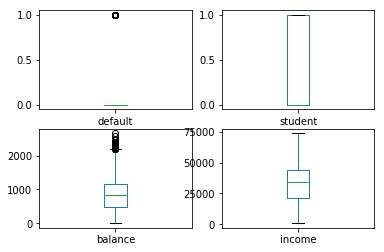

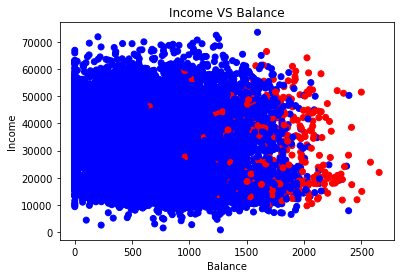

In [4]:
plt.subplot(2, 2, 1)
df['default'].plot.box()
plt.subplot(2, 2, 2)
df['student'].plot.box()
plt.subplot(2, 2, 3)
df['balance'].plot.box()
plt.subplot(2, 2, 4)
df['income'].plot.box()
plt.show()
plt.figure()
colors= {0:"blue",1:"red"}
plt.scatter(df["balance"],df["income"],c = df["default"].apply(lambda x:colors[x]))
plt.xlabel("Balance")
plt.ylabel("Income")
plt.title('Income VS Balance')
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

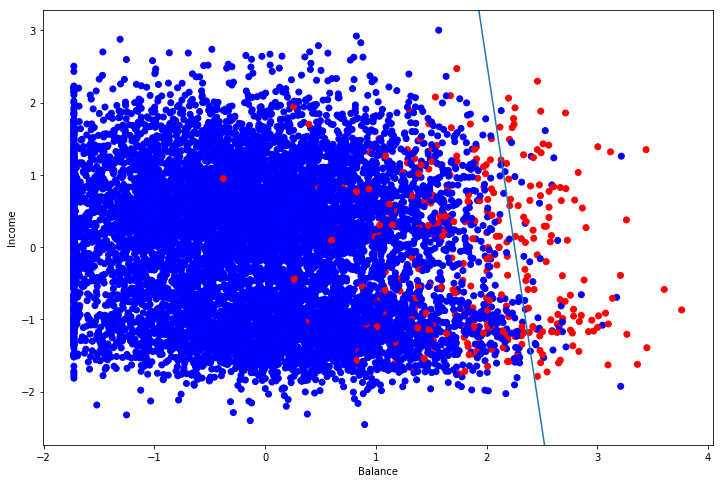

In [5]:
X = df[["balance","income"]]
y = df["default"]
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)

regr = LogisticRegression(penalty='l1')
model=regr.fit(X_train, y_train)

colors = {0:'blue',1:'red'}
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0],X[:,1],c = df['default'].apply(lambda x:colors[x]))
plt.xlabel("Balance")
plt.ylabel("Income")

bound = model.intercept_
coef = model.coef_[0]
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
x = np.arange(xmin,xmax)
y = (bound+coef[0]*x)/-coef[1]

plt.plot(x,y)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.show()

Area under the ROC curve : 0.954508


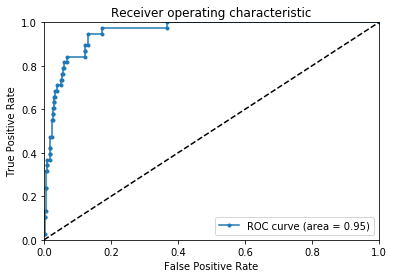

In [6]:
def generate_auc(X,y,clf_class,**kwargs):
    random_state = np.random.RandomState(0)
    
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds


fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)


5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

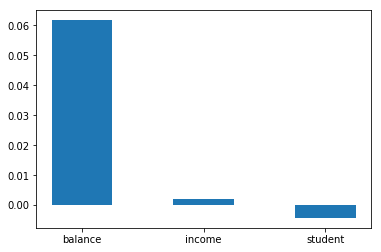

The coefficients for balance, income and student are shown respectively: [ 0.06172524  0.00212686 -0.00427   ].
Area under the ROC curve : 0.957912


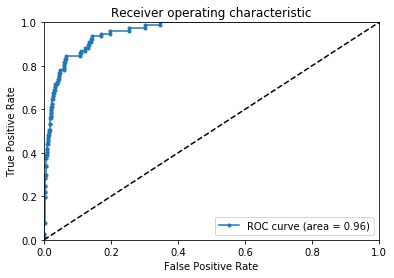

The performance did not improved very slightly when add variables.


In [7]:
from sklearn.linear_model import Ridge
X = df[['balance','income','student']]
y = df['default']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 50)

alphas = np.logspace(-9, -1, 100)
score = []
for alpha in alphas:
    clf = Ridge(alpha=alpha)
    clf.fit(X_train, y_train)
    score.append(clf.score(X_test, y_test))
opt_index = np.array(score).argmax()

clf = Ridge(alpha=alphas[opt_index])
clf.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(3), clf.coef_, 0.5)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('balance', 'income', 'student'))
rects = ax.patches
plt.show()
print ('The coefficients for balance, income and student are shown respectively: {0}.'.format(clf.coef_))

def generate_auc(X,y,clf_class,**kwargs):
    random_state = np.random.RandomState(0)
    
    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds


fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print("The performance did not improved very slightly when add variables.")

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [8]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regr, X_train, y_train, cv=8)
print(scores)
print("The model is strong because of the high cross validation score.")

[0.98  0.974 0.968 0.977 0.977 0.972 0.973 0.973]
The model is strong because of the high cross validation score.


7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

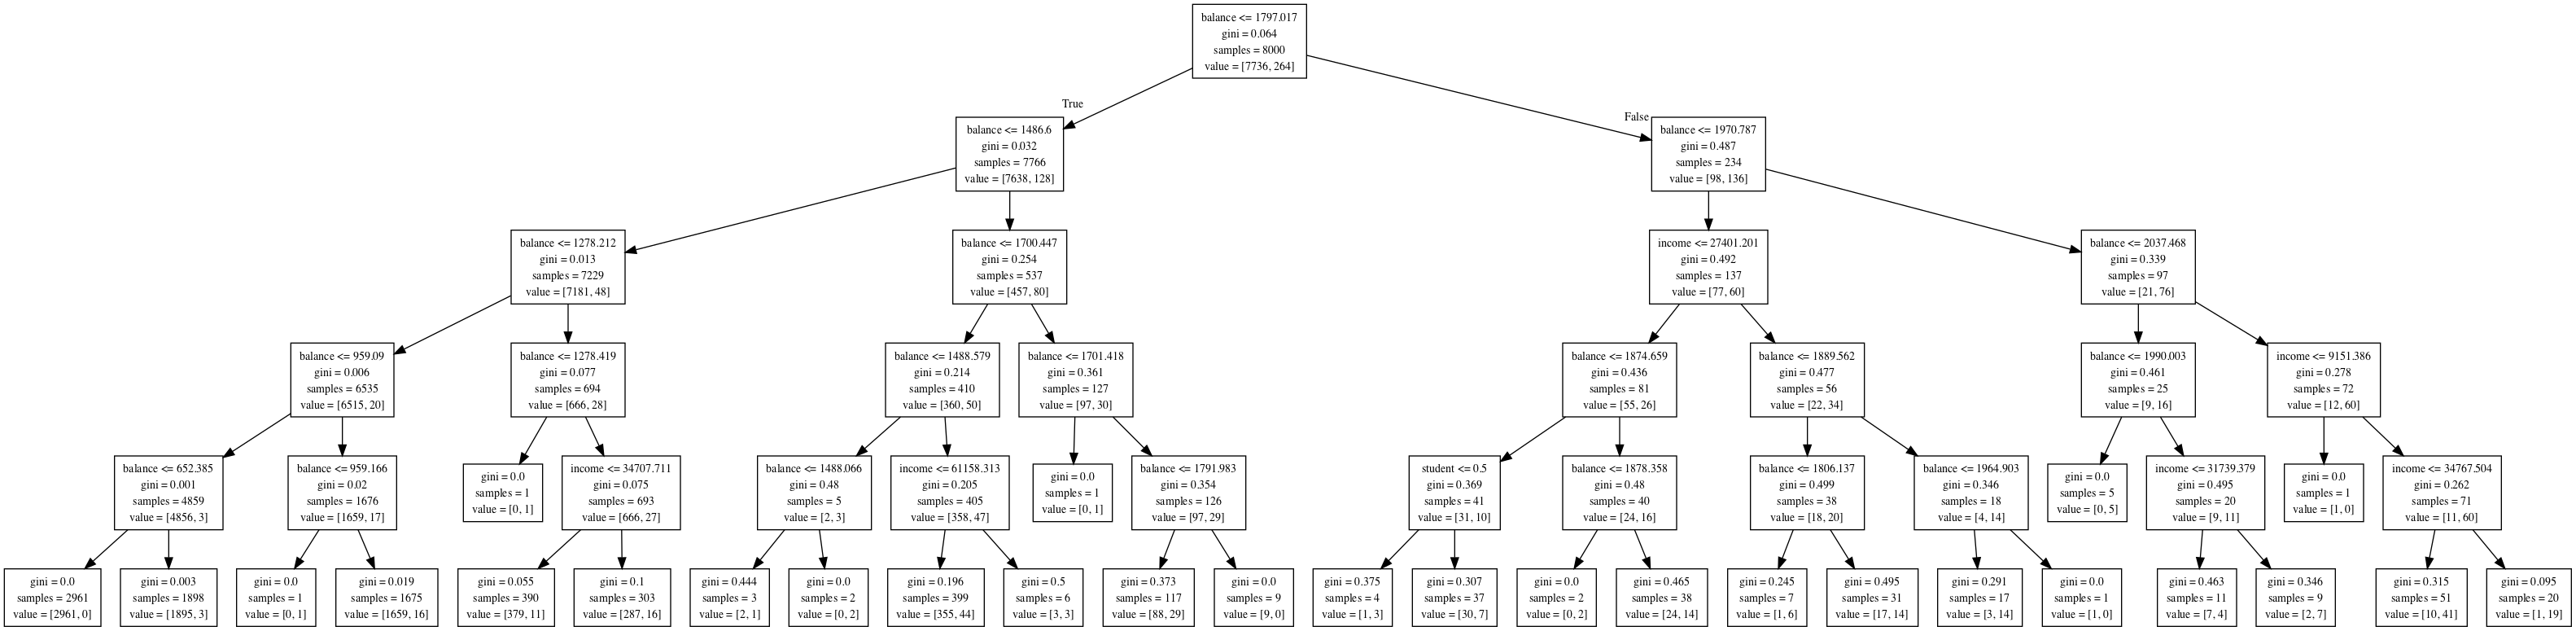

In [10]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus

X = df[['student','balance','income']]
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

clf=DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

dot_data = StringIO()  
export_graphviz(clf, out_file=dot_data, feature_names=X_train.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

8) Find the optimal decision tree depth and compute the AUC ROC. 

Optimal Depth: 5.


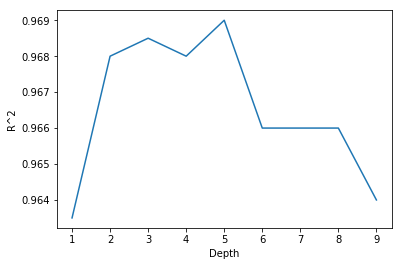

In [11]:
train_errors=[]
test_errors=[]
depths = range(1,10)
for n in depths:
    regre = DecisionTreeClassifier(max_depth=n)
    # Train the model using the training sets
    regre.fit(X_train, y_train)
    train_errors.append(regre.score(X_train,y_train))
    test_errors.append(regre.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,test_errors)
n_opt = depths[np.argmax(test_errors)]
print("Optimal Depth: {0}.".format(n_opt))
plt.show()

Area under the ROC curve : 0.687625


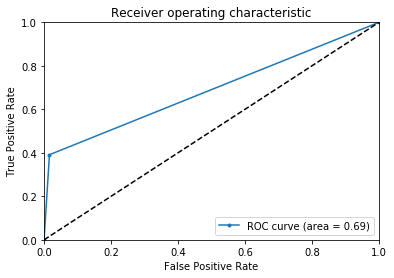

Max Depth = 1
Area under the ROC curve : 0.828181


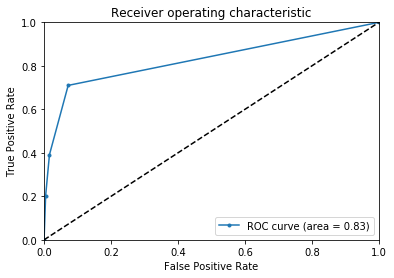

Max Depth = 2
Area under the ROC curve : 0.896562


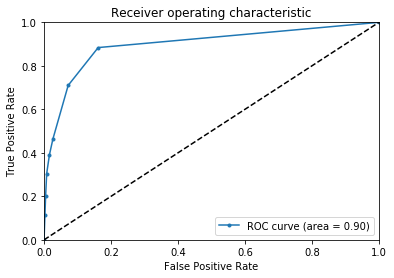

Max Depth = 3
Area under the ROC curve : 0.932550


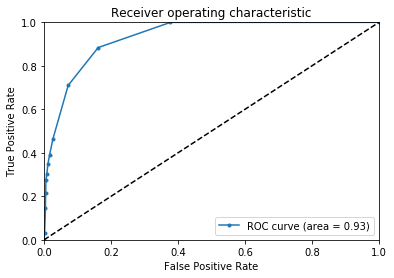

Max Depth = 4
Area under the ROC curve : 0.921757


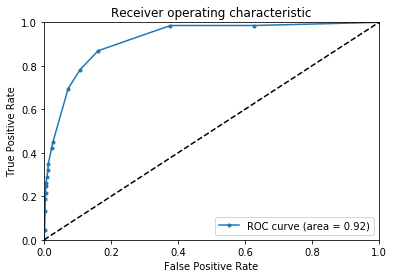

Max Depth = 5
Area under the ROC curve : 0.904683


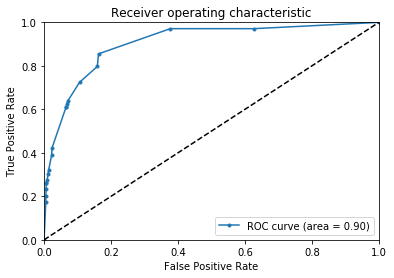

Max Depth = 6
Area under the ROC curve : 0.834508


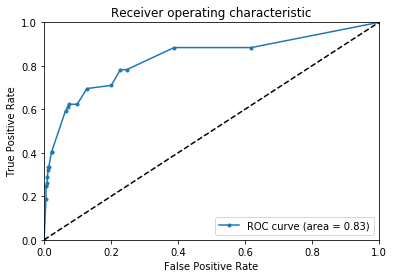

Max Depth = 7
Area under the ROC curve : 0.836092


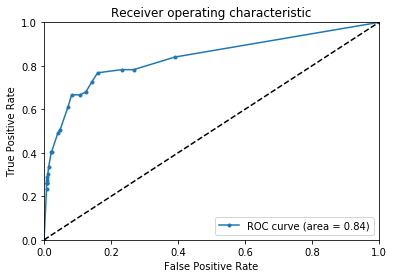

Max Depth = 8
From the following graphs, the depth of 3 or 4 seems a little bit better than the depth of 5, and depth of 4 has the highest auc.


In [12]:

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 1)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 1')
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 2)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 2')

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 3)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 3')

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 4)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 4')

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 5)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 5')

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 6)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 6')

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 7)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 7')

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 8)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 8')

print('From the following graphs, the depth of 3 or 4 seems a little bit better than the depth of 5, and depth of 4 has the highest auc.')